In [27]:
import pandas as pd

# Load datasets (replace paths with actual file locations if needed)
case_study_df = pd.read_excel('/Users/lanahuyen/UCB Bootcamp/food_delivery/data/Food Delivery Time Prediction Case Study 2.xlsx')
data_train_df = pd.read_excel('/Users/lanahuyen/UCB Bootcamp/food_delivery/data/Data_Train.xlsx')
data_test_df = pd.read_excel('/Users/lanahuyen/UCB Bootcamp/food_delivery/data/Data_Test.xlsx')
train_csv_df = pd.read_csv('/Users/lanahuyen/UCB Bootcamp/food_delivery/data/train_dataset.csv')
test_csv_df = pd.read_csv('/Users/lanahuyen/UCB Bootcamp/food_delivery/data/test_dataset.csv')

# Preview the first few rows of each dataset to understand structure
print("Case Study Dataset:\n", case_study_df.head())
print("Data Train Dataset:\n", data_train_df.head())
print("Data Test Dataset:\n", data_test_df.head())
print("Train CSV Dataset:\n", train_csv_df.head())
print("Test CSV Dataset:\n", test_csv_df.head())


Case Study Dataset:
      ID Delivery_person_ID  Delivery_person_Age  Delivery_person_Ratings  \
0  4607     INDORES13DEL02                   37                      4.9   
1  B379     BANGRES18DEL02                   34                      4.5   
2  5D6D     BANGRES19DEL01                   23                      4.4   
3  7A6A    COIMBRES13DEL02                   38                      4.7   
4  70A2     CHENRES12DEL01                   32                      4.6   

   Restaurant_latitude  Restaurant_longitude  Delivery_location_latitude  \
0            22.745049             75.892471                   22.765049   
1            12.913041             77.683237                   13.043041   
2            12.914264             77.678400                   12.924264   
3            11.003669             76.976494                   11.053669   
4            12.972793             80.249982                   13.012793   

   Delivery_location_longitude Type_of_order Type_of_vehicle  Tim

In [34]:
# Concatenate supplementary datasets for enhanced training data
combined_train_data = pd.concat([data_train_df, train_csv_df], ignore_index=True)


In [36]:
import numpy as np

# Haversine formula for distance calculation
def haversine(lat1, lon1, lat2, lon2):
    R = 6371  # Earth radius in kilometers
    d_lat = np.radians(lat2 - lat1)
    d_lon = np.radians(lon2 - lon1)
    a = np.sin(d_lat / 2)**2 + np.cos(np.radians(lat1)) * np.cos(np.radians(lat2)) * np.sin(d_lon / 2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
    return R * c

# Calculate distance and add it as a new column
case_study_df['distance_km'] = case_study_df.apply(lambda row: haversine(
    row['Restaurant_latitude'], row['Restaurant_longitude'],
    row['Delivery_location_latitude'], row['Delivery_location_longitude']), axis=1)

# Preview to check if 'distance_km' was added correctly
print(case_study_df[['Restaurant_latitude', 'Restaurant_longitude', 'Delivery_location_latitude', 'Delivery_location_longitude', 'distance_km']].head())


   Restaurant_latitude  Restaurant_longitude  Delivery_location_latitude  \
0            22.745049             75.892471                   22.765049   
1            12.913041             77.683237                   13.043041   
2            12.914264             77.678400                   12.924264   
3            11.003669             76.976494                   11.053669   
4            12.972793             80.249982                   13.012793   

   Delivery_location_longitude  distance_km  
0                    75.912471     3.025149  
1                    77.813237    20.183530  
2                    77.688400     1.552758  
3                    77.026494     7.790401  
4                    80.289982     6.210138  


In [37]:
# One-hot encode categorical columns
case_study_df = pd.get_dummies(case_study_df, columns=['Type_of_order', 'Type_of_vehicle'], drop_first=True)

# Preview to verify new columns were created
print(case_study_df.head())


     ID Delivery_person_ID  Delivery_person_Age  Delivery_person_Ratings  \
0  4607     INDORES13DEL02                   37                      4.9   
1  B379     BANGRES18DEL02                   34                      4.5   
2  5D6D     BANGRES19DEL01                   23                      4.4   
3  7A6A    COIMBRES13DEL02                   38                      4.7   
4  70A2     CHENRES12DEL01                   32                      4.6   

   Restaurant_latitude  Restaurant_longitude  Delivery_location_latitude  \
0            22.745049             75.892471                   22.765049   
1            12.913041             77.683237                   13.043041   
2            12.914264             77.678400                   12.924264   
3            11.003669             76.976494                   11.053669   
4            12.972793             80.249982                   13.012793   

   Delivery_location_longitude  Time_taken(min)  distance_km  \
0                    7

In [38]:
# Define features (X) and target (y)
X = case_study_df.drop(columns=['Time_taken(min)'])
y = case_study_df['Time_taken(min)']


In [46]:
import random

# Step 1: Round latitude and longitude to group locations within small areas
case_study_df['rounded_lat'] = case_study_df['Delivery_location_latitude'].round(2)
case_study_df['rounded_lon'] = case_study_df['Delivery_location_longitude'].round(2)

# Step 2: Create unique locations and sample a small subset
unique_locations = case_study_df[['rounded_lat', 'rounded_lon']].drop_duplicates()
sampled_locations = unique_locations.sample(n=min(10, len(unique_locations)), random_state=1)



In [47]:
import requests
import pandas as pd

# Insert your Calendarific API Key
API_KEY_CALENDARIFIC = 'WcjTgzLuGcVjeZitkgVRhSEyLW3xjmBx'

# Cache dictionary to store holiday data for each unique date
holiday_cache = {}

def fetch_holiday_data(date, country='US'):
    # Check cache first
    if date in holiday_cache:
        return holiday_cache[date]
    
    # If date not in cache, make the API call
    url = f"https://calendarific.com/api/v2/holidays?api_key={API_KEY_CALENDARIFIC}&country={country}&year={date.year}&month={date.month}&day={date.day}"
    response = requests.get(url)
    if response.status_code == 200:
        holidays = response.json().get('response', {}).get('holidays', [])
        is_holiday = 1 if holidays else 0
        holiday_cache[date] = is_holiday  # Save result in cache
        return is_holiday
    
    # Default to 0 if API call fails
    holiday_cache[date] = 0
    return 0

# Apply holiday function with caching
case_study_df['is_holiday'] = case_study_df['Time_taken(min)'].apply(lambda x: fetch_holiday_data(pd.to_datetime(x)))

In [48]:
# Insert your Yelp API Key
API_KEY_YELP = 'n4DmA-bIdakaxHcMcj8Ubxb4LN297nn1awkjjeDCFsLhQJHMX3G4aws_OUVNJQTp7Mc6kaqePbIxG0LCWPh7KpGCNZpJM6RTjyahWI_eJe21xugWrAXtW7qwQ00pZ3Yx'
HEADERS_YELP = {'Authorization': f'Bearer {API_KEY_YELP}'}

# Step 3: Fetch restaurant data only for the sampled locations
restaurant_cache = {}

for _, row in sampled_locations.iterrows():
    lat, lon = row['rounded_lat'], row['rounded_lon']
    restaurant_cache[(lat, lon)] = fetch_restaurant_density(lat, lon)  # Run the API call only for sampled locations

# Step 4: Map restaurant data to all locations, using cached data for sampled ones and default values for others
DEFAULT_DENSITY = 5
DEFAULT_AVG_RATING = 4.0
DEFAULT_TOTAL_REVIEWS = 20

def get_restaurant_data(lat, lon):
    # If location is in cache, return its values
    return restaurant_cache.get((lat, lon), {
        'restaurant_density': DEFAULT_DENSITY,
        'average_rating': DEFAULT_AVG_RATING,
        'total_reviews': DEFAULT_TOTAL_REVIEWS
    })

# Apply restaurant data to the dataset
case_study_df['restaurant_data'] = case_study_df.apply(
    lambda row: get_restaurant_data(row['rounded_lat'], row['rounded_lon']), axis=1
)

# Separate restaurant data into individual columns and drop the temporary rounded columns
restaurant_df = pd.DataFrame(case_study_df['restaurant_data'].tolist())
case_study_df = pd.concat([case_study_df, restaurant_df], axis=1)
case_study_df.drop(columns=['restaurant_data', 'rounded_lat', 'rounded_lon'], inplace=True)

In [49]:
case_study_df.to_csv('/Users/lanahuyen/UCB Bootcamp/food_delivery/data/enhanced_case_study.csv', index=False)


In [52]:
import pandas as pd

# Load the enhanced dataset
enhanced_case_study = pd.read_csv('/Users/lanahuyen/UCB Bootcamp/food_delivery/data/enhanced_case_study.csv')


In [53]:
import numpy as np

def haversine(lat1, lon1, lat2, lon2):
    # Convert decimal degrees to radians
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    
    # Haversine formula
    d_lat = lat2 - lat1
    d_lon = lon2 - lon1
    a = np.sin(d_lat / 2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(d_lon / 2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
    R = 6371  # Earth radius in kilometers
    distance = R * c
    return distance

# Recalculate distance_km using the updated function
enhanced_case_study['distance_km'] = enhanced_case_study.apply(
    lambda row: haversine(row['Restaurant_latitude'], row['Restaurant_longitude'],
                          row['Delivery_location_latitude'], row['Delivery_location_longitude']), axis=1)


In [54]:
# Preview the updated distance values
print(enhanced_case_study[['Restaurant_latitude', 'Restaurant_longitude', 
                           'Delivery_location_latitude', 'Delivery_location_longitude', 'distance_km']].head())


   Restaurant_latitude  Restaurant_longitude  Delivery_location_latitude  \
0            22.745049             75.892471                   22.765049   
1            12.913041             77.683237                   13.043041   
2            12.914264             77.678400                   12.924264   
3            11.003669             76.976494                   11.053669   
4            12.972793             80.249982                   13.012793   

   Delivery_location_longitude  distance_km  
0                    75.912471     3.025149  
1                    77.813237    20.183530  
2                    77.688400     1.552758  
3                    77.026494     7.790401  
4                    80.289982     6.210138  


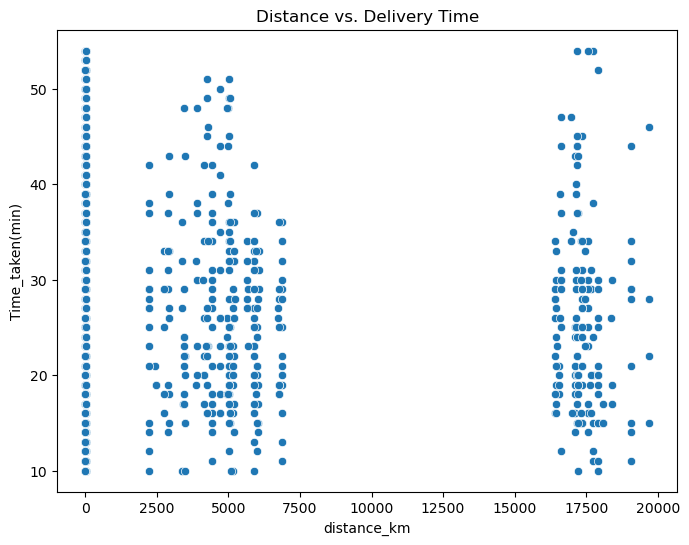

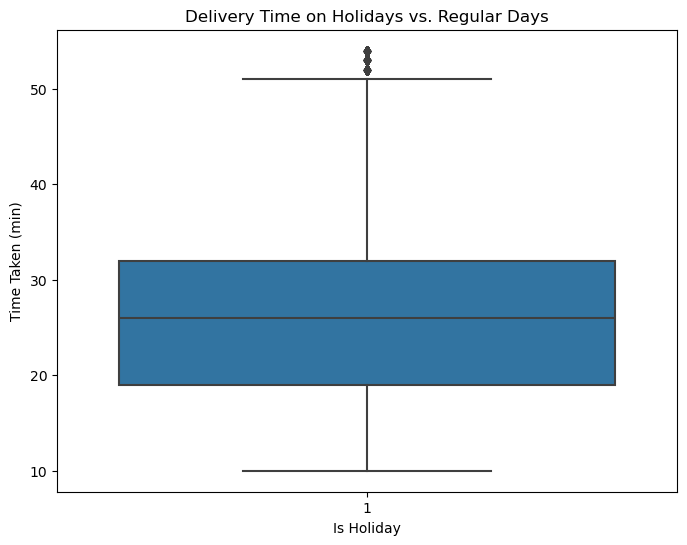

/Users/lanahuyen/anaconda3/envs/dev/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/lanahuyen/anaconda3/envs/dev/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/lanahuyen/anaconda3/envs/dev/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/lanahuyen/anaconda3/envs/dev/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprec

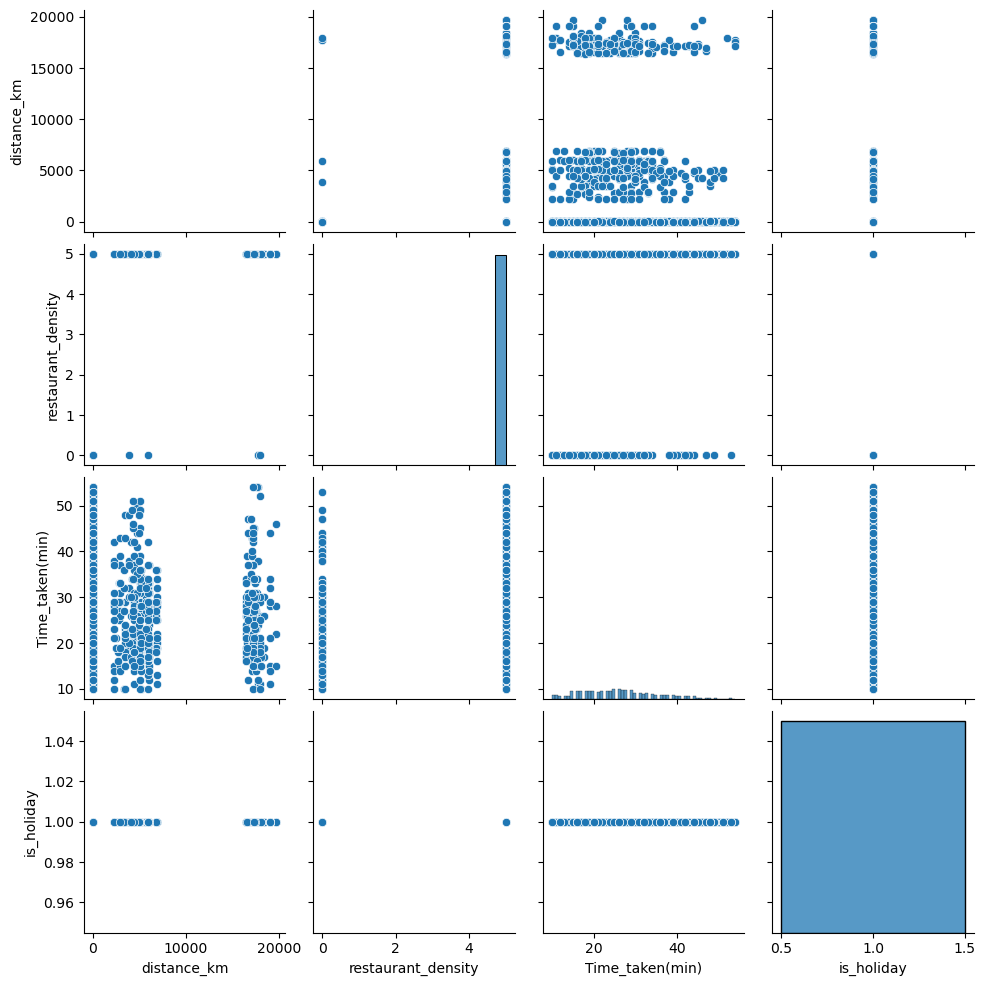

In [55]:
import matplotlib.pyplot as plt
import seaborn as sns

# Scatter plot: Distance vs. Delivery Time
plt.figure(figsize=(8, 6))
sns.scatterplot(data=case_study_df, x='distance_km', y='Time_taken(min)')
plt.title('Distance vs. Delivery Time')
plt.show()

# Boxplot: Delivery Time on Holidays vs. Regular Days
plt.figure(figsize=(8, 6))
sns.boxplot(data=case_study_df, x='is_holiday', y='Time_taken(min)')
plt.title('Delivery Time on Holidays vs. Regular Days')
plt.xlabel('Is Holiday')
plt.ylabel('Time Taken (min)')
plt.show()

# Pairplot to see relationships across multiple variables
sns.pairplot(case_study_df[['distance_km', 'restaurant_density', 'Time_taken(min)', 'is_holiday']])
plt.show()


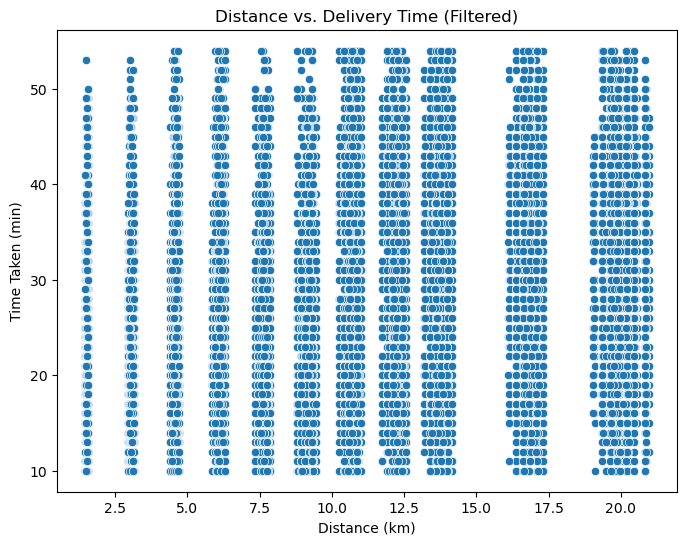

In [56]:
# Step 1: Filter out unrealistic distances after calculating
enhanced_case_study['distance_km'] = enhanced_case_study.apply(
    lambda row: haversine(row['Restaurant_latitude'], row['Restaurant_longitude'],
                          row['Delivery_location_latitude'], row['Delivery_location_longitude']), axis=1)

# Step 2: Filter for reasonable delivery distances (e.g., under 100 km)
enhanced_case_study = enhanced_case_study[enhanced_case_study['distance_km'] <= 100]

# Step 3: Re-run the scatter plot with filtered data
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 6))
sns.scatterplot(data=enhanced_case_study, x='distance_km', y='Time_taken(min)')
plt.title('Distance vs. Delivery Time (Filtered)')
plt.xlabel('Distance (km)')
plt.ylabel('Time Taken (min)')
plt.show()
